## Imports


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import struct
import time

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler


import pandas as pd
import numpy as np

##  Functions

In [242]:
# function that calculates the r squared error
def r_squared_error(y_real, y_est):
    residuals = y_real - y_est
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_real-np.mean(y_real))**2)
    return (1 - (ss_res / ss_tot))

# function that plot a boxplot for each column in a dataframe (the Y column needs to be the last in the frame)
def boxplot(data,y_value):

    categorical = data.columns.tolist()
    categorical = categorical[:-1]

    fig, ax = plt.subplots(len(categorical), 1, figsize=(15, 100))

    i=0

    for var, subplot in zip(categorical, ax.flatten()):
        sns.boxplot(x=var, y=y_value, data=data, ax=subplot, linewidth=2.5)
        ax[i].tick_params(axis='x',labelsize=15,labelrotation=30)
        ax[i].tick_params(axis='y',labelsize=15)
        ax[i].set_title(f'{y_value} vs {var}',size=18)
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        i+=1

    return plt.show()

## Data


In [3]:
# reading the data and storing it into a dataframe
data = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
# data general information
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


## Data Exploration

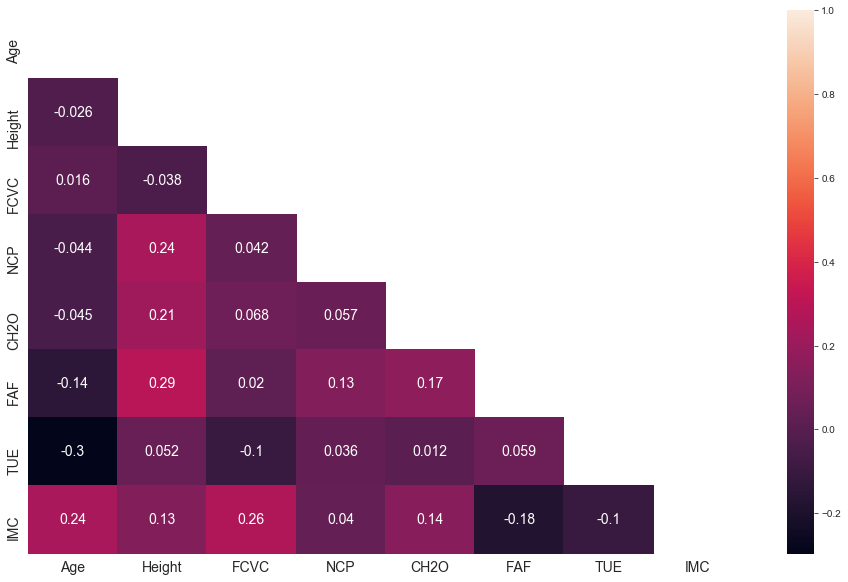

In [69]:
# correlation plot of the values from the table
mask = np.zeros_like(data_regr.iloc[:, 0:8].corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize=(16,10))
sns.heatmap(data_regr.iloc[:, 0:8].corr(),mask=mask, annot=True, annot_kws={"size": 14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

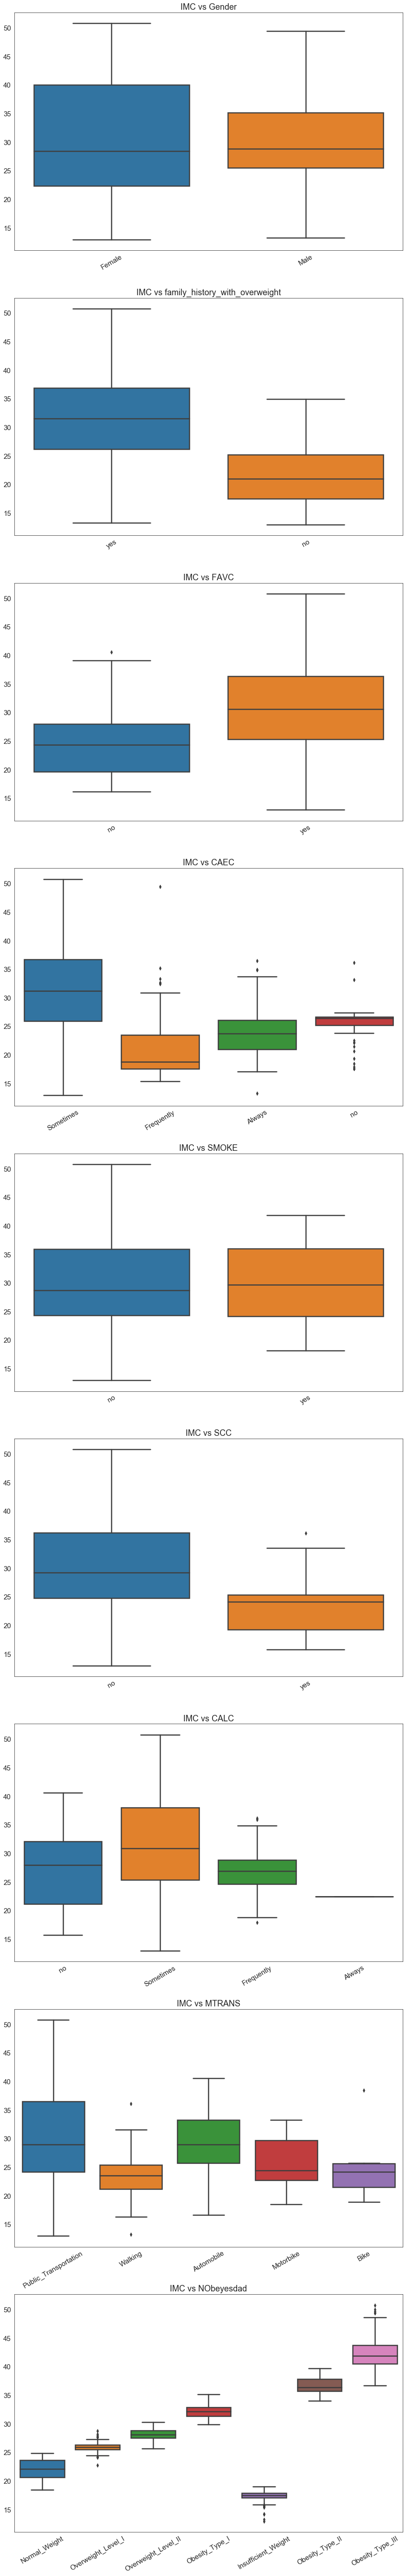

In [243]:
# making a boxplot for each categorical column in the frame 
data_cat = data['Weight']/data['Height']**2
data_cat = pd.concat([data.select_dtypes(include=['object']),data_cat],axis=1)
data_cat = data_cat.rename(columns={0: "IMC"})

boxplot(data_cat,'IMC')

## Data Transformation

In [5]:
# calculing the IMC, that will be our target for our regression model
data['IMC'] = data['Weight']/data['Height']**2
data_regr   = data.drop(columns=['NObeyesdad', 'Weight'])

In [6]:
# changing the dataframe to convert the object variables into dummies
data_regr   = pd.concat([data_regr.select_dtypes(exclude=['object']),
                         pd.get_dummies(data_regr.select_dtypes(include=['object']))],
                         axis=1)

In [7]:
# showing the results
data_regr.head()

,Age,Height,FCVC,NCP,CH2O,FAF,TUE,IMC,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,2.0,3.0,2.0,0.0,1.0,24.386526,1,0,...,0,0,0,0,1,0,0,0,1,0
1,21.0,1.52,3.0,3.0,3.0,3.0,0.0,24.238227,1,0,...,1,0,0,1,0,0,0,0,1,0
2,23.0,1.80,2.0,3.0,2.0,2.0,1.0,23.765432,0,1,...,0,0,1,0,0,0,0,0,1,0
3,27.0,1.80,3.0,3.0,2.0,2.0,0.0,26.851852,0,1,...,0,0,1,0,0,0,0,0,0,1
4,22.0,1.78,2.0,1.0,2.0,0.0,0.0,28.342381,0,1,...,0,0,0,1,0,0,0,0,1,0


## Batching

In [8]:
# separating test and train sets 
X_train, X_test, y_train, y_test = train_test_split(data_regr.drop(columns=['IMC']),data_regr['IMC'],
                                                    train_size=0.90, random_state=42)

## Training

In [17]:
# models
lr   = LinearRegression()
dtr  = DecisionTreeRegressor()
rfr  = RandomForestRegressor()
xgbr = XGBRegressor()
en   = ElasticNet()

## Linear Regression

In [44]:
# model training and parameter tuning
parameters = {'normalize': [False, True]}

lr_grid = GridSearchCV(lr,
                       parameters,
                       cv = 4,
                       n_jobs = 4,
                       verbose=True)

lr_grid.fit(X_train,y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    1.8s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=4,
             param_grid={'normalize': [False, True]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=True)

In [45]:
lr_grid.best_params_

{'normalize': False}

In [46]:
r_squared_error(y_test,lr_grid.predict(X_test))

0.49617334816151104

## Decision Tree

In [49]:
# model training and parameter tuning
parameters = {'max_depth': [5, 6, 7],
              'min_samples_leaf': [4,2]}

dtr_grid = GridSearchCV(dtr,
                        parameters,
                        cv = 4,
                        n_jobs = 4,
                        verbose=True)

dtr_grid.fit(X_train,y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    0.0s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': [5, 6, 7], 'min_samples_leaf': [4, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
    

In [51]:
dtr_grid.best_params_

{'max_depth': 7, 'min_samples_leaf': 4}

In [52]:
r_squared_error(y_test,dtr_grid.predict(X_test))

0.7550835862962006

## Random Forest

In [41]:
# model training and parameter tuning
parameters = {'max_depth': [9, 12, 15],
              'n_estimators': [50,100,150,200]}

rf_grid = GridSearchCV(rfr,
                       parameters,
                       cv = 4,
                       n_jobs = 4,
                       verbose=True)

rf_grid.fit(X_train,y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:   15.3s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [42]:
rf_grid.best_params_

{'max_depth': 15, 'n_estimators': 150}

In [43]:
r_squared_error(y_test,rf_grid.predict(X_test))

0.8803205365315564

## XGBR

In [31]:
# model training and parameter tuning
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4,3],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [200,500,700]}

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 4,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:  1.9min finished


[11:14:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'm

In [28]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 700,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

In [33]:
r_squared_error(y_test,xgb_grid.predict(X_test))

0.8907015637453184

## ElasticNet

In [56]:
# model training and parameter tuning
parameters = {"l1_ratio":[0,0.25,.5,.75,1],
              "alpha":[0.5,1,2],
              "max_iter":[2000]}

en_grid = GridSearchCV( en,
                        parameters,
                        cv = 4,
                        n_jobs = 4,
                        verbose=True)

en_grid.fit(X_train,y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    1.1s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': [0.5, 1, 2],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'max_iter': [2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [57]:
en_grid.best_params_

{'alpha': 0.5, 'l1_ratio': 1, 'max_iter': 2000}

In [58]:
r_squared_error(y_test,en_grid.predict(X_test))

0.37289274544546913